<a href="https://www.kaggle.com/code/chloemaurel/transfer-learning?scriptVersionId=123115605" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# General Information

This notebook aim to test the performance of transfer learning on this hand-writting digit dataset. 

Two well-known CNN model will be tested: VGG16 and ResnNet50.

To start, we will implement only feature extraction from both model and evaluate using the accuracy and f1 score metric. If the accuracy & loss are not good enough, I would implement partial fine-tuning or full fine-tuning.



# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2 as cv
import tensorflow as tf
import keras
from keras import backend as K
from tensorflow.keras.utils import img_to_array
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Flatten, Dropout, UpSampling2D, GlobalAveragePooling2D
from keras.layers import RandomFlip, RandomRotation, RandomZoom
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import pickle
from tensorflow.keras.models import Sequential

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
train_csv = pd.read_csv("train.csv")
test_csv = pd.read_csv("test.csv")
train_csv.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
test_csv.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
num_classes = len(train_csv['label'].unique())
num_classes

10

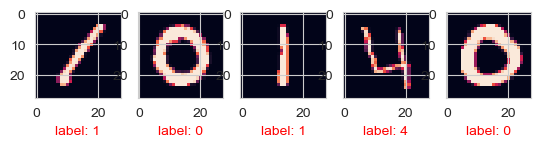

In [4]:
IMG_SIZE = (28,28,1)
# Sample digit image
sample_images = train_csv.iloc[0:5,1:].values.reshape((-1,)+IMG_SIZE)
fig, axs = plt.subplots(1, sample_images.shape[0])
for i,img in enumerate(sample_images):
    axs[i].imshow(img)
    axs[i].set_xlabel(f'label: {train_csv.iloc[i,0]}')
    axs[i].xaxis.label.set_color('red')

## Preparation of Data

- X : from 28 * 28 grey-scale pixels to 75 * 75 RGB-scale pixels 
- y: from a column of numbers to an array of 10 one-hot-encoding classes.

In [4]:
# Preprocessing Data
X = train_csv.iloc[:,1:].values.reshape((-1,)+(28,28,1)).astype(np.float32)
list = []
for i in range(len(X)):
    X_rgb = cv.cvtColor(X[i], cv.COLOR_GRAY2RGB)
    X_rgb = cv.resize(X_rgb, (75,75))
    list.append(X_rgb)
X_rgb = np.array(list)
# Normalization
X_rgb /= 255

y = train_csv.iloc[:,0].astype(np.int32)
y = pd.get_dummies(y)

print(f'X shape: {format(X_rgb.shape)}')
print(f'y shape: {format(y.shape)}')

X shape: (42000, 75, 75, 3)

y shape: (42000, 10)


In [19]:
X_submission = test_csv.iloc[:,:].values.reshape((-1,)+(28,28,1)).astype(np.float32)
list = []
for i in range(len(X_submission)):
    X_t = cv.cvtColor(X_submission[i], cv.COLOR_GRAY2RGB)
    X_t = cv.resize(X_t, (75,75))
    list.append(X_t)
X_submission = np.array(list)
# Normalization
X_submission /= 255

print(f'X test shape: {format(X_submission.shape)}')

X test shape: (28000, 75, 75, 3)


## Train/Val/Test data splitting

In [5]:
# Splitting Dataset
X_train, X_val, y_train, y_val = train_test_split(X_rgb,y,test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val,y_val,test_size=0.5)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (33600, 75, 75, 3)

y_train shape: (33600, 10)

X_val shape: (4200, 75, 75, 3)

y_val shape: (4200, 10)

X_test shape: (4200, 75, 75, 3)

y_test shape: (4200, 10)


### X_train and X_val transformed into tensors

In [6]:
X_train = tf.convert_to_tensor(X_train)
X_val = tf.convert_to_tensor(X_val)
X_test = tf.convert_to_tensor(X_test)
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)
y_test = tf.convert_to_tensor(y_test)

Metal device set to: Apple M1


2023-03-21 17:41:05.050845: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.

2023-03-21 17:41:05.051380: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## F1 score common function

In [7]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Loading pre-trained models (ResNet50/VGG16)

# ResNet50

### Feature extraction

In [8]:
model = Sequential()

model.add(tf.keras.applications.resnet50.ResNet50(input_shape = (75, 75, 3), 
                                include_top = False, 
                                weights = 'imagenet'))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.layers[0].trainable = False

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', f1_m])

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 4d473c1dd8becc155b73f8504c6f6626 so we will re-download the data.


94765736/94765736 [==============================] - 157s 2us/step


In [9]:
model.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  

                                                                 

 flatten (Flatten)           (None, 18432)             0         

                                                                 

 dense (Dense)               (None, 128)               2359424   

                                                                 

 dense_1 (Dense)             (None, 10)                1290      

                                                                 


Total params: 25,948,426

Trainable params: 2,360,714

Non-trainable params: 23,587,712

_________________________________________________________________


In [10]:
history = model.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=5)

Epoch 1/5


2023-03-21 17:44:41.920628: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz

2023-03-21 17:44:44.807573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1050/1050 [==============================] - ETA: 0s - loss: 0.7193 - accuracy: 0.8283 - f1_m: 0.7075

2023-03-21 17:47:25.494285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1050/1050 [==============================] - 182s 169ms/step - loss: 0.7193 - accuracy: 0.8283 - f1_m: 0.7075 - val_loss: 0.3684 - val_accuracy: 0.9079 - val_f1_m: 0.8964

Epoch 2/5

1050/1050 [==============================] - 176s 168ms/step - loss: 0.2946 - accuracy: 0.9240 - f1_m: 0.9186 - val_loss: 0.2468 - val_accuracy: 0.9374 - val_f1_m: 0.9350

Epoch 3/5

1050/1050 [==============================] - 178s 170ms/step - loss: 0.2154 - accuracy: 0.9421 - f1_m: 0.9403 - val_loss: 0.2043 - val_accuracy: 0.9433 - val_f1_m: 0.9433

Epoch 4/5

1050/1050 [==============================] - 182s 174ms/step - loss: 0.1782 - accuracy: 0.9497 - f1_m: 0.9495 - val_loss: 0.1595 - val_accuracy: 0.9555 - val_f1_m: 0.9589

Epoch 5/5

1050/1050 [==============================] - 179s 170ms/step - loss: 0.1520 - accuracy: 0.9573 - f1_m: 0.9571 - val_loss: 0.1395 - val_accuracy: 0.9619 - val_f1_m: 0.9624


In [11]:
pickle.dump(model, open('model_resnet50_feature_extraction.sav', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:

...layers

......dense

.........vars

............0

............1

......dense_1

.........vars

............0

............1

......flatten

.........vars

......functional

.........layers

............activation

...............vars

............activation_1

...............vars

............activation_10

...............vars

............activation_11

...............vars

............activation_12

...............vars

............activation_13

...............vars

............activation_14

...............vars

............activation_15

...............vars

............activation_16

...............vars

............activation_17

...............vars

............activation_18

...............vars

............activation_19

...............vars

............activation_2

...............vars

............activation_20

...............vars

............activation_21

...............vars

............activation_2

In [12]:
model.evaluate(X_test,y_test)

132/132 [==============================] - 20s 151ms/step - loss: 0.1396 - accuracy: 0.9617 - f1_m: 0.9596


[0.13955087959766388, 0.9616666436195374, 0.9595722556114197]

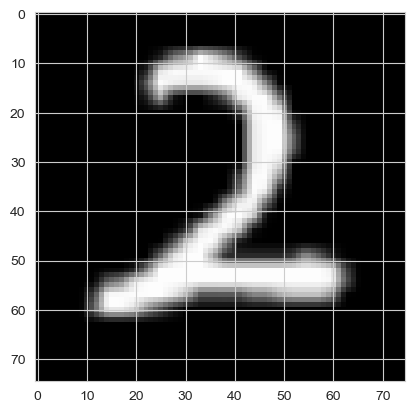

In [13]:
plt.imshow(np.array(X_test[4]), interpolation='nearest')
plt.show()

In [15]:
np.array(np.argmax(y_test[4]))

array(2)

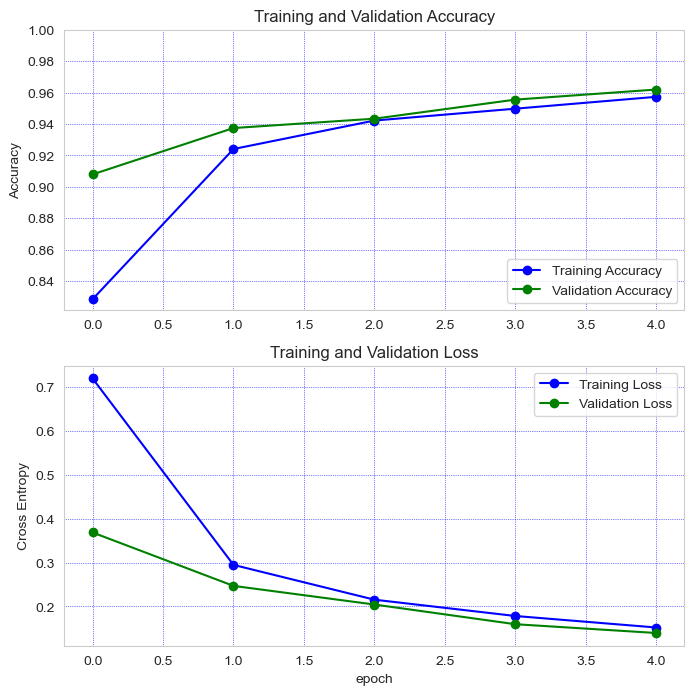

In [16]:
acc_res50_feature = history.history['accuracy']
val_acc_res50_feature = history.history['val_accuracy']

loss_res50_feature = history.history['loss']
val_loss_res50_feature = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.grid(color='b', linestyle='dotted', linewidth=0.5)
plt.plot(acc_res50_feature, 'o-',label='Training Accuracy', color='b')
plt.plot(val_acc_res50_feature, 'o-',label='Validation Accuracy', color='g')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.grid(color='b', linestyle='dotted', linewidth=0.5)
plt.plot(loss_res50_feature, 'o-',label='Training Loss', color='b')
plt.plot(val_loss_res50_feature, 'o-',label='Validation Loss', color='g')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Submission of ResNet50 result

In [20]:
result_test = model.predict(X_submission)

2023-03-21 18:03:06.222244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


875/875 [==============================] - 117s 131ms/step


In [21]:
result = np.argmax(result_test,1)
result

array([2, 0, 9, ..., 3, 9, 2])

In [ ]:
submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submission

In [ ]:
submission['Label'] = np.argmax(result_test,1)
submission

In [ ]:
submission.to_csv('submission_resnet50.csv', index=False)

## Displaying Test images and predicted label

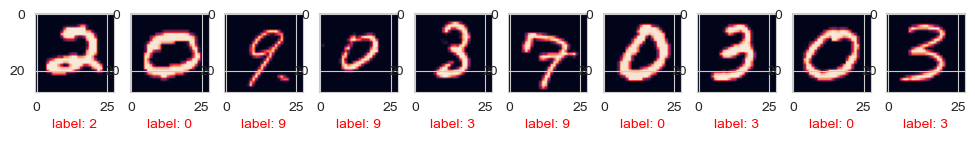

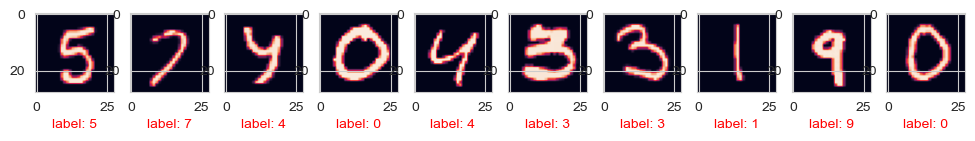

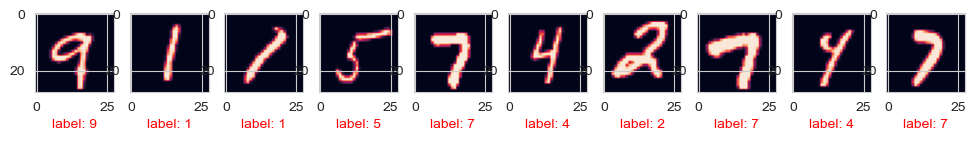

In [27]:
IMG_SIZE = (28,28,1)
# Sample digit image
sample_images = test_csv.iloc[0:10,0:].values.reshape((-1,)+IMG_SIZE)
sample_images2 = test_csv.iloc[10:20,0:].values.reshape((-1,)+IMG_SIZE)
sample_images3 = test_csv.iloc[20:30,0:].values.reshape((-1,)+IMG_SIZE)
fig, axs = plt.subplots(1, sample_images.shape[0], figsize=(12,12))
for i,img in enumerate(sample_images):
    axs[i].imshow(img)
    axs[i].set_xlabel(f'label: {result[i]}')
    axs[i].xaxis.label.set_color('red')
fig, axs = plt.subplots(1, sample_images2.shape[0],figsize=(12,12))
for i,img in enumerate(sample_images2):
    axs[i].imshow(img)
    axs[i].set_xlabel(f'label: {result[i + 10]}')
    axs[i].xaxis.label.set_color('red')
fig, axs = plt.subplots(1, sample_images3.shape[0],figsize=(12,12))
for i,img in enumerate(sample_images3):
    axs[i].imshow(img)
    axs[i].set_xlabel(f'label: {result[i + 20]}')
    axs[i].xaxis.label.set_color('red')

#### Accuracy : 0.93% on 30 random examples

## Confusion Matrix ResNet50

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
accuracies = []
def confusion(y_true,y_pred):
    fig = plt.figure(figsize=(8,8)) # Set Figure
    mat = confusion_matrix(y_true, y_pred) # Confusion matrix

    # Plot Confusion matrix
    sns.set(font_scale=1)
    sns.heatmap(mat.T, square=True, annot=True, cbar=True, cmap="crest",fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values');
    plt.show();
    print(accuracy_score(y_true,y_pred))
    accuracies.append(accuracy_score(y_true,y_pred))

In [29]:
y_pred = model.predict(X_test)

2023-03-21 18:12:35.611898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 22s 154ms/step


In [31]:
np.argmax(np.array(y_test),1)

array([3, 7, 9, ..., 7, 8, 5])

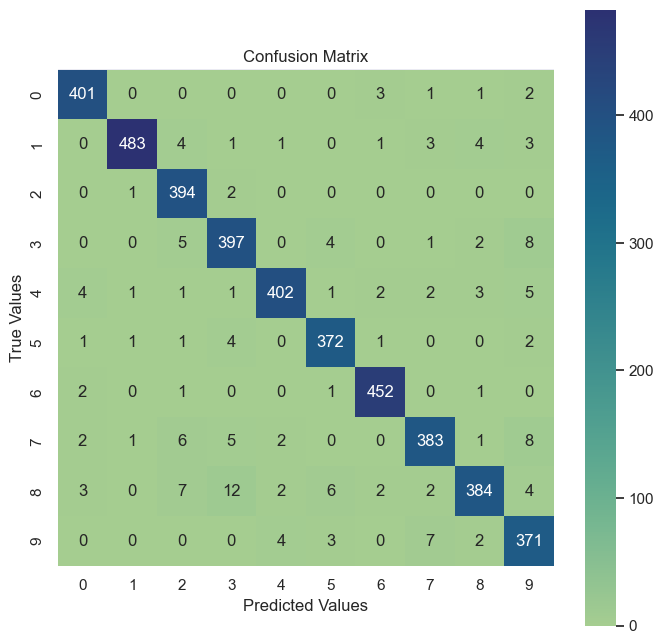

0.9616666666666667


In [32]:
confusion(np.argmax(np.array(y_test),1),np.argmax(y_pred,1))

# VGG16

In [35]:
model_vgg16 = Sequential()

model_vgg16.add(tf.keras.applications.vgg16.VGG16(input_shape = (75, 75, 3), 
                                include_top = False, 
                                weights = 'imagenet'))

model_vgg16.add(Flatten())
model_vgg16.add(Dense(128, activation='relu'))
model_vgg16.add(Dense(10, activation='softmax'))

model_vgg16.layers[0].trainable = False

model_vgg16.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', f1_m])

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 6d6bbae143d832006294945121d1f1fc so we will re-download the data.


58889256/58889256 [==============================] - 87s 1us/step


In [36]:
model_vgg16.summary()

Model: "sequential_2"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 vgg16 (Functional)          (None, 2, 2, 512)         14714688  

                                                                 

 flatten_1 (Flatten)         (None, 2048)              0         

                                                                 

 dense_2 (Dense)             (None, 128)               262272    

                                                                 

 dense_3 (Dense)             (None, 10)                1290      

                                                                 


Total params: 14,978,250

Trainable params: 263,562

Non-trainable params: 14,714,688

_________________________________________________________________


In [37]:
history_vgg16 = model_vgg16.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=5)

Epoch 1/5


2023-03-21 18:28:11.801429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1050/1050 [==============================] - ETA: 0s - loss: 0.5856 - accuracy: 0.8826 - f1_m: 0.7627

2023-03-21 18:31:07.441641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1050/1050 [==============================] - 197s 186ms/step - loss: 0.5856 - accuracy: 0.8826 - f1_m: 0.7627 - val_loss: 0.2258 - val_accuracy: 0.9500 - val_f1_m: 0.9453

Epoch 2/5

1050/1050 [==============================] - 178s 170ms/step - loss: 0.1725 - accuracy: 0.9585 - f1_m: 0.9559 - val_loss: 0.1395 - val_accuracy: 0.9645 - val_f1_m: 0.9627

Epoch 3/5

1050/1050 [==============================] - 87s 83ms/step - loss: 0.1175 - accuracy: 0.9696 - f1_m: 0.9684 - val_loss: 0.1054 - val_accuracy: 0.9736 - val_f1_m: 0.9724

Epoch 4/5

1050/1050 [==============================] - 88s 84ms/step - loss: 0.0924 - accuracy: 0.9757 - f1_m: 0.9753 - val_loss: 0.0911 - val_accuracy: 0.9767 - val_f1_m: 0.9750

Epoch 5/5

1050/1050 [==============================] - 91s 87ms/step - loss: 0.0773 - accuracy: 0.9788 - f1_m: 0.9788 - val_loss: 0.0786 - val_accuracy: 0.9781 - val_f1_m: 0.9781


In [38]:
pickle.dump(model_vgg16, open('model_vgg16_feature_extraction.sav', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:

...layers

......dense

.........vars

............0

............1

......dense_1

.........vars

............0

............1

......flatten

.........vars

......functional

.........layers

............conv2d

...............vars

..................0

..................1

............conv2d_1

...............vars

..................0

..................1

............conv2d_10

...............vars

..................0

..................1

............conv2d_11

...............vars

..................0

..................1

............conv2d_12

...............vars

..................0

..................1

............conv2d_2

...............vars

..................0

..................1

............conv2d_3

...............vars

..................0

..................1

............conv2d_4

...............vars

..................0

..................1

............conv2d_5

...............vars

...............

In [ ]:
loaded_model_vgg16 = pickle.load(open('model_vgg16_feature_extraction.sav', 'rb'))

## VGG16 result visualization

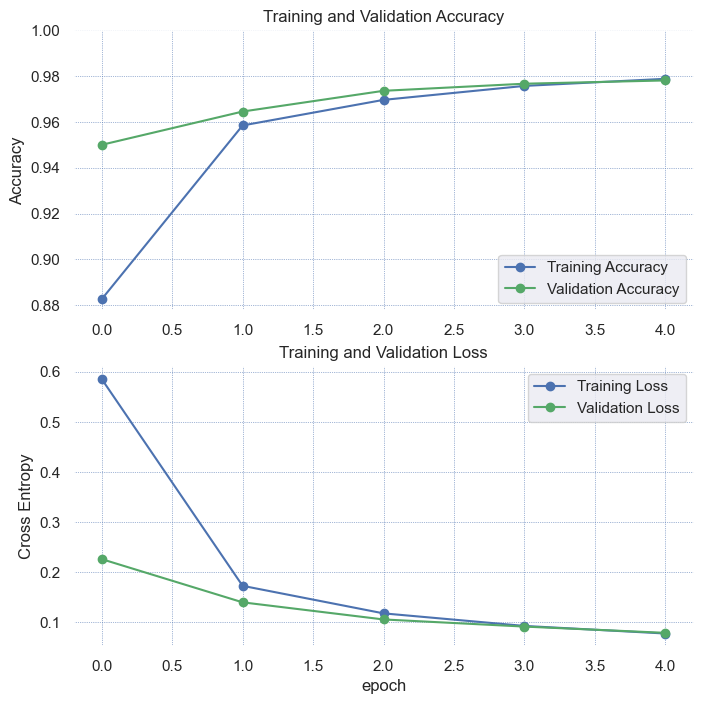

In [47]:
acc_vgg16 = history_vgg16.history['accuracy']
val_acc_vgg16 = history_vgg16.history['val_accuracy']

loss_vgg16 = history_vgg16.history['loss']
val_loss_vgg16 = history_vgg16.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1).set_facecolor('white')
plt.grid(color='b',linestyle='dotted', linewidth=0.5)
plt.plot(acc_vgg16, 'o-',label='Training Accuracy', color='b')
plt.plot(val_acc_vgg16, 'o-',label='Validation Accuracy', color='g')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2).set_facecolor('white')
plt.grid(color='b', linestyle='dotted', linewidth=0.5)
plt.plot(loss_vgg16, 'o-',label='Training Loss', color='b')
plt.plot(val_loss_vgg16, 'o-',label='Validation Loss', color='g')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Submitting VGG16 result

In [48]:
result_test_vgg16 = model_vgg16.predict(X_submission)

2023-03-21 18:53:00.568582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


875/875 [==============================] - 64s 72ms/step


In [49]:
result_vgg16 = np.argmax(result_test_vgg16,1)
result_vgg16

array([2, 0, 9, ..., 3, 9, 2])

In [ ]:
submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submission

In [ ]:
submission['Label'] = result_vgg16
submission

In [ ]:
submission.to_csv('submission_vgg16.csv', index=False)

## Displaying test.csv prediction

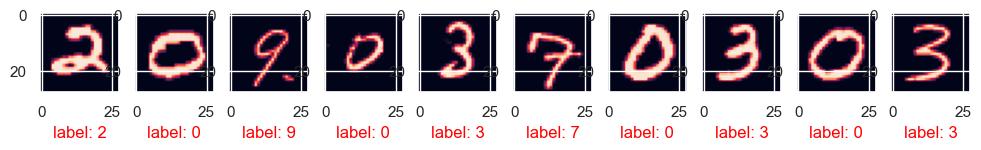

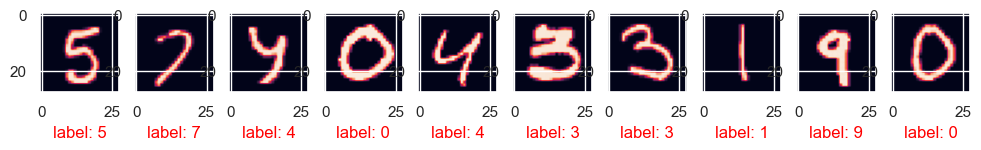

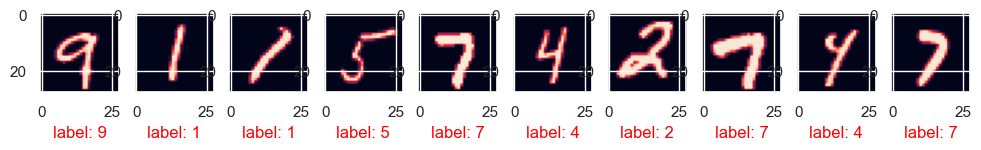

In [50]:
IMG_SIZE = (28,28,1)
# Sample digit image
sample_images = test_csv.iloc[0:10,0:].values.reshape((-1,)+IMG_SIZE)
sample_images2 = test_csv.iloc[10:20,0:].values.reshape((-1,)+IMG_SIZE)
sample_images3 = test_csv.iloc[20:30,0:].values.reshape((-1,)+IMG_SIZE)
fig, axs = plt.subplots(1, sample_images.shape[0], figsize=(12,12))
for i,img in enumerate(sample_images):
    axs[i].imshow(img)
    axs[i].set_xlabel(f'label: {result_vgg16[i]}')
    axs[i].xaxis.label.set_color('red')
fig, axs = plt.subplots(1, sample_images2.shape[0],figsize=(12,12))
for i,img in enumerate(sample_images2):
    axs[i].imshow(img)
    axs[i].set_xlabel(f'label: {result_vgg16[i + 10]}')
    axs[i].xaxis.label.set_color('red')
fig, axs = plt.subplots(1, sample_images3.shape[0],figsize=(12,12))
for i,img in enumerate(sample_images3):
    axs[i].imshow(img)
    axs[i].set_xlabel(f'label: {result_vgg16[i + 20]}')
    axs[i].xaxis.label.set_color('red')

#### accuracy : 100% on 30 examples

## Confusion Matrix VGG16

In [52]:
y_pred = model_vgg16.predict(X_test)

2023-03-21 18:59:29.532080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 10s 72ms/step


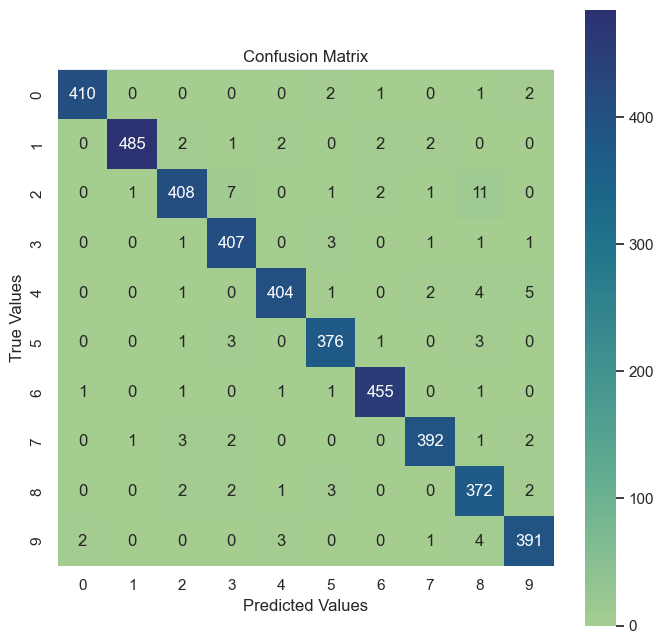

0.9761904761904762


In [53]:
confusion(np.argmax(np.array(y_test),1),np.argmax(y_pred,1))

# Conclusion

The Hand-written Digit Recognizer competition provided an opportunity to consolidate computer vision and supervised classification algorithm skills. The implementation of transfer learning techniques using two different CNN architectures, VGG16 and ResNet50, allowed for a comparison of their performance on the dataset. VGG16 outperformed ResNet50 with an accuracy of 0.978, which is slightly better than traditional algorithms like SVM and K-NN. ResNet50 achieved an accuracy of 0.962, still comparable to non-parametric models. 

While both CNN models performed well, VGG16 proved to be the more efficient choice for this particular competition. Additionally, we could further fine-tune the VGG16 model by fine-tuning its layers to get better results, but the need for such complexity is not necessary since it would require a large computational cost to gain 0.01-0.015 in accuracy (i.e 0.99).